# Analysing business with SQL and Jupyter


## How to write SQLite module queries within a jupyter notebook

You need to first create a connection object that will represent the database. 

You should have a sqlite database file, which will be the argument of the connection:
```
> import sqlite3
> connection = sqlite3.connect("your_databse.db")
```
Then, in order to run commands to sqlite, you need a cursos object that can fetch the queries results. The cursos is a method of connection. 
```
> cursor = connection.cursor()
```

Say that you have a table called `table` in your database `your_databse.db`. Then you can create a query as follows:
```
> query = "SELECT * FROM table LIMIT 10;"
> display_first_10 = cursor.execute(query).fetchall()
> print(display_first_10)
> connection.close()
```

To write SQLite queries in Jupiter is also useful because it allows you to use pandas thus producing dataframe outputs. (You need to import pandas and sqlite3 first!)
```
> conn = sqlite3.connect("your_databse.db")
> query = "SELECT * FROM table LIMIT 10;"
> pd.read_sql_query(query, conn)

```

I have a short project showing sql queries in python with pandas in https://nahusznaj.github.io/projects/sqlite-python/



Now, in this case we will do something that is even better: we will use [the connection object as context manager](https://docs.python.org/3/library/sqlite3.html#using-the-connection-as-a-context-manager).

Context managers take care of opening and closing the connection to the database, and keeps the database secure. There's an [article](https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/) by Jeff Knupp to read about this.

So let's start with this project calling the imports and using the context manager.

(before I start, datquest.io solutions are available here https://github.com/dataquestio/solutions/blob/master/Mission191Solutions.ipynb)


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Let's define some useful functions to run queries that give pandas dataframes as outputs, run commands that execute queries:

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

And a function that uses `run_query()` to return a list of all tables and views in our databases. This will be handy in order to check the state of our database as we work. 

In [4]:
def show_tables():
    q = """SELECT
                name,
                type
            FROM sqlite_master
            WHERE type IN ("table","view");"""
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Analysing genres by sales

We have been given four artists with their respective genre that are not currently in the USA market. We need to select the three most profitable ones to make available.

So, we aim to see which genres sell the most in the USA. I will address this question in steps:

1. count how many trakcs each genre has
2. count the track sales by genre
3. count the track sales by genre from customers in the USA
4. calculate the percentage of sales that each genre represents among the total sales in the USA

Let's find out which genres sell the most tracks in the USA.

First, I will count all the tracks organised by their genre.

In [6]:
q = """ 
    SELECT 
            g.name genre,
            COUNT(t.track_id) total_no_of_tracks
    FROM genre g
    LEFT JOIN track t
    ON t.genre_id = g.genre_id
    GROUP BY 1 ORDER BY 2 DESC
"""
run_query(q)

,genre,total_no_of_tracks
0,Rock,1297
1,Latin,579
2,Metal,374
3,Alternative & Punk,332
4,Jazz,130
5,TV Shows,93
6,Blues,81
7,Classical,74
8,Drama,64
9,R&B/Soul,61


Now, I'd like a query to tell me all the tracks separated by genre that were sold (and thus have a quantity number in an invoice line):

In [7]:
q = """ 
    SELECT 
            g.name genre,
            SUM(il.quantity) no_of_tracks
    FROM genre g
    INNER JOIN track t
    ON t.genre_id = g.genre_id
    INNER JOIN invoice_line il 
    ON il.track_id = t.track_id
    GROUP BY 1 ORDER BY 2 DESC
"""
run_query(q)

,genre,no_of_tracks
0,Rock,2635
1,Metal,619
2,Alternative & Punk,492
3,Latin,167
4,R&B/Soul,159
5,Blues,124
6,Jazz,121
7,Alternative,117
8,Easy Listening,74
9,Pop,63


Let's pull out numbers for sold tracks from USA customers:

In [8]:
q = """ 
    SELECT 
            g.name genre,
            SUM(il.quantity) usa_no_of_tracks
    FROM genre g
    INNER JOIN track t
    ON t.genre_id = g.genre_id
    INNER JOIN invoice_line il 
    ON il.track_id = t.track_id
    INNER JOIN invoice i 
    ON i.invoice_id = il.invoice_id
    INNER JOIN customer c
    ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    GROUP BY 1 ORDER BY 2 DESC
"""


run_query(q)

,genre,usa_no_of_tracks
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Latin,22
7,Pop,22
8,Hip Hop/Rap,20
9,Jazz,14


In [9]:
l= """    SELECT 
            SUM(il.quantity)
    FROM invoice_line il 
    INNER JOIN invoice i 
    ON i.invoice_id = il.invoice_id
    INNER JOIN customer c
    ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    LIMIT 20
                                """

run_query(l)

,SUM(il.quantity)
0,1051


Now let's add some code to calculate the percentage: for this I want to divide the number of tracks of a specific genre sold to USA based customers over the total number of tracks sold to USA customers.

In [10]:
q = """ 
/* This will take all the invoice lines referring to customers whose country is the USA */
    WITH usa_customers_sales AS (
    SELECT 
            IL.*
    FROM invoice_line il 
    INNER JOIN invoice i 
    ON i.invoice_id = il.invoice_id
    INNER JOIN customer c
    ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
                                )


    SELECT 
            g.name genre,
            SUM(il.quantity) usa_no_of_tracks,
            100 * CAST( SUM(il.quantity) AS FLOAT) / (SELECT COUNT(*) FROM usa_customers_sales) percentage_usa_sales_by_genre
    FROM genre g
    INNER JOIN track t
    ON t.genre_id = g.genre_id
    INNER JOIN invoice_line il 
    ON il.track_id = t.track_id
    INNER JOIN invoice i 
    ON i.invoice_id = il.invoice_id
    INNER JOIN customer c
    ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
    GROUP BY 1 ORDER BY 2 DESC
"""


run_query(q)

,genre,usa_no_of_tracks,percentage_usa_sales_by_genre
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


Now we can use the output of this query to create plots:

In [11]:
genre_sales_usa = run_query(q)

In [12]:
genre_sales_usa.head()

,genre,usa_no_of_tracks,percentage_usa_sales_by_genre
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309


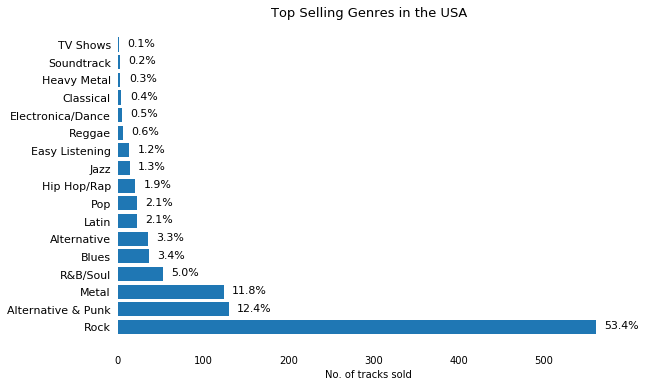

In [13]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  


plt.ylim=(0,16)
plt.setp(ax, yticks=np.arange(0,17, step=1)) 
ax.set_title('Top Selling Genres in the USA', fontsize=13)


plt.barh(range(len(genre_sales_usa['usa_no_of_tracks'])), genre_sales_usa['usa_no_of_tracks'], align='center')
plt.ylabel('')
plt.xlabel('No. of tracks sold')
plt.yticks(range(len(genre_sales_usa['usa_no_of_tracks'])), list(genre_sales_usa['genre']), fontsize = 11)
percentage = genre_sales_usa['percentage_usa_sales_by_genre']


for label, i in enumerate(ax.patches):
    ax.text(i.get_width()+10, i.get_y()+.3, 
            (np.round(percentage[label], decimals = 1)).astype(str) + '%' , fontsize=11)

Well the code I needed to write to plot this is admitedly cumbersome. I'm sure there are more elegant ways to use annotations, labelling and bar plots. I could have used seaborn (I have used it a lot in my first ever data [visualisation project](https://nahusznaj.github.io/projects/exploration-scholarships/)), for instance.

The solution presented by [dataquest.io](https://github.com/dataquestio/solutions/blob/master/Mission191Solutions.ipynb) staff requires a lot less lines too. 

But I wanted to do it my way, because I understand my code better than theirs.

Let's discuss the plot: clearly, the genres that  sell most tracks in the USA are lead by far by Rock, with 53.4 %, with Alternative & Punk and Metal with similar percentage of sales 12.4 % and 11.8 % respectively.


Now, we have been given the following artists to select from Regal (Hip-Hop), Red Tone	(Punk), Meteor and the Girls (Pop), Slim Jim Bites	(Blues).

Based on the information above, we will select three in this order 
1. Red Tone (Punk), 
2. Slim Jim Bites	(Blues) and 
3. Meteor and the Girls (Pop).

Evidently, an artist in the Rock genre would be more profitable.

### Employee perfomance


Each customer gets assigned to a sales support agent within the company when they first make a purchase. I will analyse the employees sales perfomance.



- I will write a query that finds the total dollar amount of sales assigned to each sales support agent within the company.
- I will analyse and plot the results of your query.


## Sales in dollars assigned to each sales support agent

In [14]:
q = """ 
    SELECT 
            e.first_name || " " || e.last_name employee,
            SUM(i.total) total_sales
    FROM employee e
    INNER JOIN customer c
    ON e.employee_id = c.support_rep_id
    INNER JOIN invoice i 
    ON c.customer_id = i.customer_id
    GROUP BY e.employee_id ORDER BY 2 DESC
"""


run_query(q)

,employee,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


Let's use the table `employee` to see whether the difference can be explained or whether there is actually a better perfoming employee.

In [15]:
q = """ 
    SELECT 
            e.first_name || " " || e.last_name employee,
            SUM(i.total) total_sales,
            hire_date
    FROM employee e
    INNER JOIN customer c
    ON e.employee_id = c.support_rep_id
    INNER JOIN invoice i 
    ON c.customer_id = i.customer_id
    GROUP BY e.employee_id ORDER BY 2 DESC
"""


run_query(q)

,employee,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


In [16]:
sales_per_employee = run_query(q)

In [17]:
sales_per_employee

,employee,total_sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


In [18]:
sales_per_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
employee       3 non-null object
total_sales    3 non-null float64
hire_date      3 non-null object
dtypes: float64(1), object(2)
memory usage: 152.0+ bytes


In [19]:
delta_usd_12 = sales_per_employee['total_sales'][1] - sales_per_employee['total_sales'][2]

In [20]:
delta_usd_01 = sales_per_employee['total_sales'][0] - sales_per_employee['total_sales'][1]

In [21]:
delta_usd_02 = sales_per_employee['total_sales'][0] - sales_per_employee['total_sales'][2]

In [22]:
import time
import datetime

In [23]:
sales_per_employee['hire_date'] = pd.to_datetime(sales_per_employee['hire_date'])

In [24]:
delta_weeks_12 =  (sales_per_employee['hire_date'][1] - sales_per_employee['hire_date'][2]).days
delta_weeks_12 = delta_weeks_12 / 7
delta_weeks_12

-23.857142857142858

In [25]:
delta_weeks_01 = (sales_per_employee['hire_date'][0] - sales_per_employee['hire_date'][1]).days
delta_weeks_01 = delta_weeks_01 / 7
delta_weeks_01

-4.571428571428571

In [26]:
delta_weeks_02 = (sales_per_employee['hire_date'][0] - sales_per_employee['hire_date'][2]).days
delta_weeks_02 = delta_weeks_02 / 7
delta_weeks_02

-28.428571428571427

In [27]:
delta_usd_02 / delta_weeks_02

-11.875025125628211

In [28]:
delta_usd_12 / delta_weeks_12

-7.9674251497006621

While it is not exactly explained by the time that the employees have been working, it is not unreasonable to consider that Jane Peacock sold more because she's been in the company for longer. 

Let's create a plot:

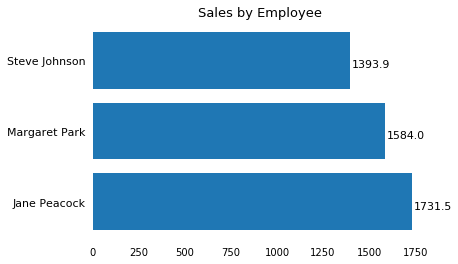

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  


plt.ylim=(0,16)
plt.setp(ax, yticks=np.arange(0,17, step=1)) 
ax.set_title('Sales by Employee', fontsize=13)


plt.barh(range(len(sales_per_employee['total_sales'])), sales_per_employee['total_sales'], align='center')
plt.ylabel('')
plt.yticks(range(len(sales_per_employee['total_sales'])), list(sales_per_employee['employee']), fontsize = 11)
sales = sales_per_employee['total_sales']


for label, i in enumerate(ax.patches):
    ax.text(i.get_width()+10, i.get_y()+.3, 
            (np.round(sales[label], decimals = 1)).astype(str), fontsize=11)

## Sales per country

Let's analyse the sales for customers from each different country. We will ignore the country from the billing address in the `invoice` table, and consider only the country in the `customer` table.

In particular, I will calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

For this task I will use a somewhat more complex techinque for writing the queries. The main issue is that there are many countries with only one customer, which I would like to group as "other" instead of considering each country separately. 

In [30]:
q = """ SELECT 
              country,
              COUNT(customer_id) no_of_customers
        FROM customer
        GROUP BY country ORDER BY 2

"""
run_query(q)

,country,no_of_customers
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Chile,1
5,Denmark,1
6,Finland,1
7,Hungary,1
8,Ireland,1
9,Italy,1


Next, I want to see whether the customers make more than one purchase. This will clarify the difference in the data in tables `customer` and `invoice`. 

In [31]:
q = """ SELECT 
               COUNT(customer_id),
               billing_country
        FROM invoice
        GROUP BY 2 ORDER BY 2
        LIMIT 5

"""
run_query(q)

,COUNT(customer_id),billing_country
0,5,Argentina
1,10,Australia
2,9,Austria
3,7,Belgium
4,61,Brazil


I'll need to be careful not to mix these two `invoice.billing_country` and `customer.country`!

First, let's start by designing a query that will replace the country name by 'Other' if that country has only one customer.

In [32]:
run_query("""    SELECT count(*)
                 FROM customer
                 where country = 'Argentina'
 """)

,count(*)
0,1


In [108]:
run_query("""    SELECT count(*)
                 FROM customer
                 where country = 'Brazil'
 """)

,count(*)
0,5


In [111]:
run_query("""    SELECT count(*)
                 FROM customer
                 where country = 'Australia'
 """)

,count(*)
0,1


In [112]:
run_query("""    SELECT count(*)
                 FROM customer
                 where country = 'Austria'
 """)

,count(*)
0,1


In [109]:
run_query("""    SELECT count(*)
                 FROM customer
                 where country = 'USA'
 """)

,count(*)
0,13


So I would like to generalise this query so that it goes through each country and replaces by "other" if there's only one custmer or leaves the country otherwise.

I will use the `CASE` syntax:



In [115]:
q = """SELECT
           CASE
               WHEN (
                     SELECT count(*)
                     FROM customer
                     where country = c.country
                    ) = 1 THEN "Other"
               ELSE c.country
               END AS 
               country,
           c.customer_id
           FROM customer c
           ORDER BY country
      
     """

run_query(q)

,country,customer_id
0,Brazil,1
1,Brazil,10
2,Brazil,11
3,Brazil,12
4,Brazil,13
5,Canada,3
6,Canada,14
7,Canada,15
8,Canada,29
9,Canada,30


Recall that I want: 

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

So I will add `invoice_line` to the previous query, as `invoice_line` has the data that I need:

In [33]:
q = """
SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
"""

run_query(q)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1
5,USA,18,6,1,1163,0.99,1
6,USA,18,7,1,1164,0.99,1
7,USA,18,8,1,1165,0.99,1
8,USA,18,9,1,1166,0.99,1
9,USA,18,10,1,1167,0.99,1


In [35]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort  /* this CASE code is the heart of the whole trick to order them
                        so that I force Other to be at the bottom,
                        and then I can use this in the ORDER BY part */
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


Now that we have the data, let's create a pandas dataframe and run some visualisations.

In [36]:
sales_by_country = run_query(sales_by_country) 

In [37]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dc6c390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11dc4a860>]], dtype=object)

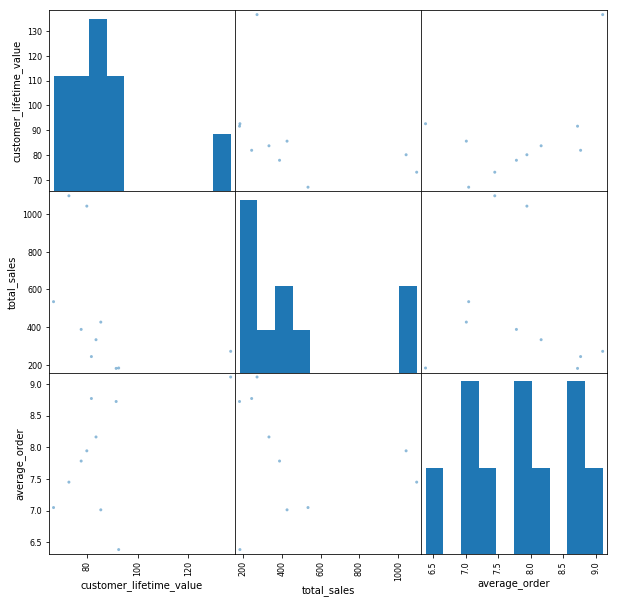

In [39]:
scatter_matrix(sales_by_country[['customer_lifetime_value', 'total_sales', 'average_order']],
               figsize = (10,10))



This is not that useful... 

Let's try some bar plots.

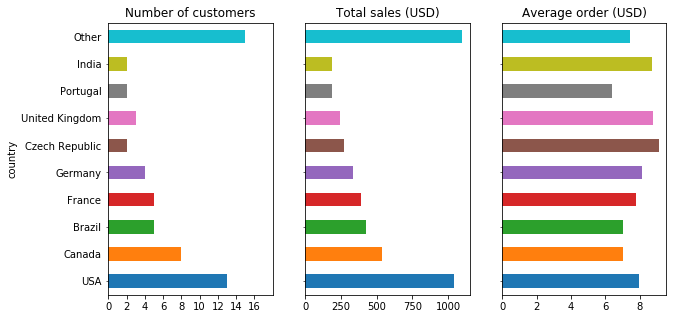

In [142]:
f, (ax3, ax1, ax2) = plt.subplots(1,3, figsize = (10,5), sharey=True)

ax3 = sales_by_country[:].plot.barh(x='country',
                            y='customers', 
                            ax = ax3,
                            legend = False
                                   )

ax3.set_title("Number of customers")
ax3.set_xticks(np.arange(0, 18, step=2))
ax3.set_xlim(0,18)



ax1 = sales_by_country[:].plot.barh(x='country',
                            y='total_sales', 
                            ax = ax1,
                            legend = False
                                   )

ax1.set_title("Total sales (USD)")
#ax1.set_xticks(np.arange(0, 0.2, step=0.05))
#ax1.set_xlim(0,0.2)


ax2 = sales_by_country[:].plot.barh(x='country',
                                    y='average_order', 
                                    ax = ax2,
                                    legend = False
                                   )

ax2.set_title("Average order (USD)")
ax2.set_ylabel('')

ax1.tick_params(bottom="on", top="off", left="off", right="off")
ax2.tick_params(bottom="on", top="off", left="off", right="off")
ax3.tick_params(bottom="on", top="off", left="off", right="off")


Some observations:

- other countries gather more customers than any other country, and their total sales amount to more money than the USA (the country with most customers and largest amount of sales). However, Other's average order is not the largest. There is more quantity of orders and customers but they have less value each in average.

- the trend of quantity of customers per country is proportionate to the trend in total sales, almost. While the Czech Republic has less customers than the UK, the total sales of the former are higher than in the latter.

- there is even more disparity between the amount of customers and the average per order: while the USA has more customers and the total sales with USA customers is the highest, there are many countries that have higher average sales than the USA.

There are other ways to visualise this:

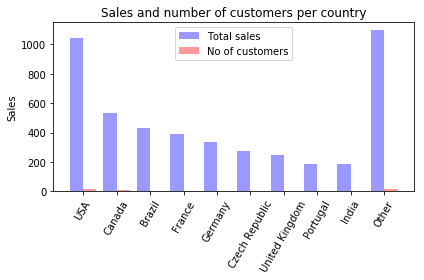

In [127]:
fig, ax = plt.subplots()

index = np.arange(len(sales_by_country['country']))
bar_width = 0.4
opacity = 0.4

rects1 = ax.bar(index, sales_by_country.total_sales, bar_width,
                alpha=opacity, color='b',
                label='Total sales')

rects2 = ax.bar(index + bar_width, sales_by_country.customers, bar_width,
                alpha=opacity, color='r',
                label='No of customers')

ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.set_title('Sales and number of customers per country')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sales_by_country['country'], rotation = 60)
ax.legend()

fig.tight_layout()
plt.show()

The scale differences make it awkward to appreciate the data, so this plot is not good! There is a better way to visualise this, which is by using percentages.

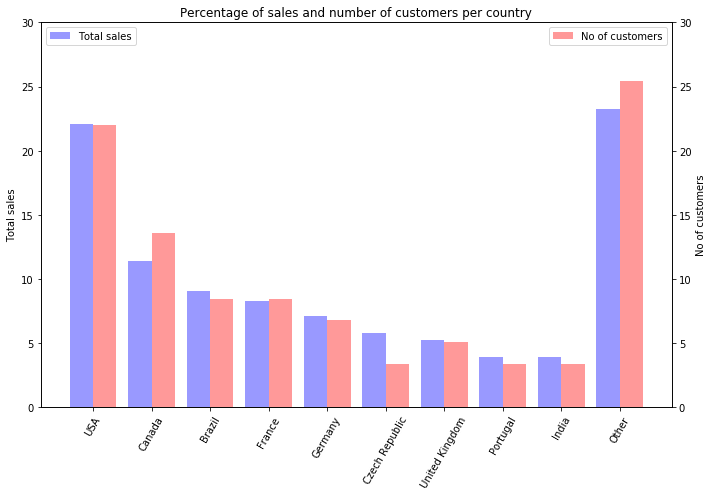

In [126]:
fig, ax_f = plt.subplots(figsize=(10, 7))
ax_c = ax_f.twinx()

index = np.arange(len(sales_by_country['country']))
bar_width = 0.4

opacity = 0.4

total_sales =  100 * sales_by_country.total_sales / sales_by_country.total_sales.sum()
customers =  100 * sales_by_country.customers / sales_by_country.customers.sum()

ax_f.bar(index, total_sales , bar_width,
                alpha=opacity, color='b',
                label='Total sales')

ax_c.bar(index + bar_width, customers, bar_width,
                alpha=opacity, color='r',
                label='No of customers')

ax_f.set_xlabel('')
ax_f.set_ylabel('Total sales')
ax_f.set_title('Percentage of sales and number of customers per country')
ax_f.set_xticks(index + bar_width / 2)
ax_f.set_xticklabels(sales_by_country['country'], rotation = 60)
ax_f.set_ylim(0,30)
ax_f.legend(loc = 'upper left')

ax_c.set_ylabel('No of customers')
ax_c.set_ylim(0,30)
ax_c.legend(loc = 'upper right')

fig.tight_layout()
plt.show()

Let's see the data of the average sale per country by looking at the difference from the mean:

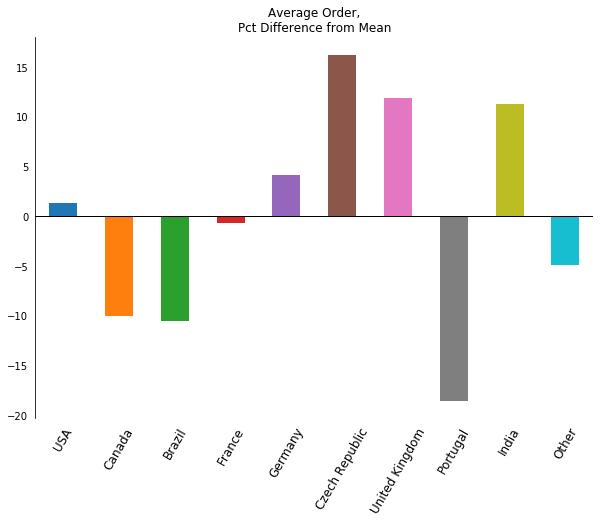

In [151]:
fig, ax = plt.subplots(figsize=(10, 7))

distance_to_average = ( sales_by_country["average_order"] * 100 / sales_by_country["average_order"].mean() ) - 100
distance_to_average.plot.bar(
    title="Average Order,\nPct Difference from Mean"
)
ax.tick_params(top="off", right="off", left="off", bottom="off")
ax.axhline(0, color='k', linewidth = 1)
ax.set_xticklabels(sales_by_country['country'], rotation = 60, fontsize = 12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

Looking at these two last plots, we can make the following considerations:

India, UK and Czech Republic have the best average sales.

Yet, there are not many customers from these countries so it would be too risky to extrapolate a behaviour from this dataset. Perhaps a pilot campaign could be arrange before making big investments in these markets.

### Full album purchases

We'd like to calculate the percentage of purchases of individual tracks vs whole albums, so that management can use this data to make informed strategic decisions.

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

Customers cannot purchase a whole album, and then add individual tracks to that same purchase. 


So what we want to do is to calculate the number of invoices that have all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. 

- to do so, we can pull the list of tracks from an invoice;
- find the album that these list of tracks belong to;
- compare the list of tracks with the album.

For the second step we can just compare one track id from the invoice with the albums to check which album it is.


#### List of tracks from each invoice







In [161]:
#List the tracks from each purchase:

run_query( """ SELECT 
                i.invoice_id,
                il.track_id
        FROM invoice i
        INNER JOIN invoice_line il
        ON i.invoice_id = il.invoice_id
""")

,invoice_id,track_id
0,1,1158
1,1,1159
2,1,1160
3,1,1161
4,1,1162
5,1,1163
6,1,1164
7,1,1165
8,1,1166
9,1,1167


We need to find out whether each invoice is either a full album purchase or not.

Each invoice is either a full album or not, so if we pick one `track_id` from the invoice and identify an album that includes that track, we can then comapare the list of tracks of that album with the list of tracks of that invoice. 

So I'll run the same query again but selecting one track per purchase (invoice):

In [175]:
run_query(
"""WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL  /* Compare the track list that obtains from the album 
                               selected by the fixed track first_track_id
                               with 
                               the track list obtained from the tracks including in the invoice
                                and give as output what's in the former that is not in the latter.
                             
                             */
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
                              /* Compare the track list obtained from the tracks including in the invoice
                               with 
                               the track list that obtains from the album selected by the fixed track first_track_id
                               and give as output what's in the former that is not in the latter.
                             */
                 
                 
             THEN "yes"  /* Given the AND operator, if both are null, then it will mean that they are exactly the 
                             same list of tracks! which means the invoice has the same tracks than the album */
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs""")

,invoice_id,first_track_id,album_purchase
0,1,1158,yes
1,2,201,no
2,3,2516,no
3,4,748,no
4,5,1986,yes
5,6,30,no
6,7,42,no
7,8,81,no
8,9,196,no
9,10,2663,no


In [177]:

#Now I want to count and return percentages over the total invoices!

run_query('''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) * 100 / ( SELECT COUNT(*) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
''')

,album_purchase,number_of_invoices,percent
0,no,500,81.433225
1,yes,114,18.566775


It seems like changing the scheme to making available only selected songs from albums would compromise 18% of the sales. Thus is it not recommmended, based on this information only, to change the scheme.